In [1]:
import pandas as pd
import xarray as xr
from argopy import DataFetcher as ArgoDataFetcher
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt

import numpy as np
from math import sqrt
from scipy.linalg import cholesky, cho_solve
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.special import gamma, kv
import vincenty

from sklearn.model_selection import train_test_split

In [2]:
#Helper functions

def depth_zone(d: float) -> str:
    """
    Classify the input as one of "Epipelagic", "Mesopelagic", "Bathypelagic"
    
    Input:
        d: float
            depth of sea, between 0 and 2000
    Return:
        zone: str
            one of "Epipelagic", "Mesopelagic", and "Bathypelagic"
    """
    if 0<= d <= 200:
        return "Epipelagic"
    elif 200 < d <= 1000:
        return "Mesopelagic"
    else:
        return "Bathypelagic"
    
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(dat: dt.datetime) -> str:
    """
    Returns the season of a particular date
    
    Input:
        date: datetime
            a date
    Return:
        season: str
    """
    if isinstance(dat, dt.datetime):
        dat = dat.date()
    dat = dat.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= dat <= end)

In [3]:
def fetch_data(start_time: str, end_time: str, attribute: str,
               min_lon: float = -180, max_lon: float = 180, 
               min_lat: float = -90, max_lat: float = 90, 
              min_dep: float = 0, max_dep: float = 2000, ) -> pd.DataFrame:
    """
    Fetch Argo data using the API, with the specified locations, 
    time frame, depth, and attributes.
    
    Inputs:
        start_time, end_time: str, required
            the desired time frame. Should be in format 'yyyy-mm-dd'
        attribute: str, required
            The desired type of attributes from one of 'salinity' or 'temp'.
        min_lon, max_lon: float
            the desired range of longitudes between -180 and 180
        min_lat, max_lat: float
            the desired range of latitudes between -90 and 90
        min_depth, max_depth: float
            the desired depth between 0 and 2000
    
    Return:
        result: pd.DataFrame
            A data frame containing float no., season, location, depth (m), depth zone, 
            temp/salinity
    """
    
    #Check input
    assert -180 <= min_lon <= max_lon <= 180, "Please enter valid min_lon or max_lon" 
    assert -90 <= min_lat <= max_lat <= 90, "Please enter valid min_lat or max_lat" 
    assert 0 <= min_dep <= max_dep <= 2000, "Please enter valid min_dep or max_dep" 
    
    try:
        dt.datetime.strptime(start_time, "%Y-%m-%d")
        dt.datetime.strptime(end_time, "%Y-%m-%d")
    except:
        raise Exception("Please enter a valid start_time or end_time.")
        
    assert attribute in ["salinity", "temp"]
    
    #Fetch data from Argo API and store in xarr as an xarray
    reg = [min_lon, max_lon, min_lat, max_lat, min_dep, max_dep, start_time, end_time]
    # print("Downloading data from Argo...")
    xarr = ArgoDataFetcher().region(reg).to_xarray()
    df = xarr.to_dataframe()[["PRES", "PSAL", "TEMP", "LATITUDE", "LONGITUDE", "TIME"]]
    
    #TODO: Check there are enough points. How many points should we aim for?
    
    #Classify based on depth
    df["Depth Zone"] = df["PRES"].apply(depth_zone)
    
    #Classify based on season
    df["Season"] = df["TIME"].apply(get_season)
    
    #TODO: Check for coastlines
    
    #Get the desired attributes
    if attribute == "salinity":
        df = df[["TIME", "PRES", "LATITUDE", "LONGITUDE", "Depth Zone", "Season", "PSAL"]]
    else:
        df = df[["TIME", "PRES", "LATITUDE", "LONGITUDE", "Depth Zone", "Season", "TEMP"]]
    
    return df
        

In [5]:
data = fetch_data('2012-06-01', '2012-12-01', "temp", -83, 29, 46, 73, 0, 2000)
data = data.loc[(data['Season'] == 'Spring') & (data['Depth Zone'] == 'Epipelagic' )]

In [138]:
X = data.loc[:, ['LATITUDE','LONGITUDE']]
y = data.loc[:, ['TEMP']]

X_trn = X.iloc[0:500]
y_trn = y.iloc[0:500]

In [155]:
%%time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(length_scale=1.5)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_trn, y_trn)

CPU times: user 1.95 s, sys: 6.1 ms, total: 1.96 s
Wall time: 2.02 s


/accounts/campus/shahzar/.conda/envs/argos/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1.5), random_state=0)

In [156]:
min(X['LATITUDE']), max(X['LATITUDE'])

(46.027, 72.3949184)

In [157]:
min(X['LONGITUDE']), max(X['LONGITUDE'])

(-57.50699996948242, 20.633)

In [158]:
lat_span = np.linspace(46, 73, 401)
lon_span = np.linspace(-57, 21, 401)

In [159]:
lat, lon = np.meshgrid(lat_span, lon_span)
pts = np.vstack([lat.ravel(), lon.ravel()]).T

In [160]:
y_pred = gpr.predict(pts)

/accounts/campus/shahzar/.conda/envs/argos/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(


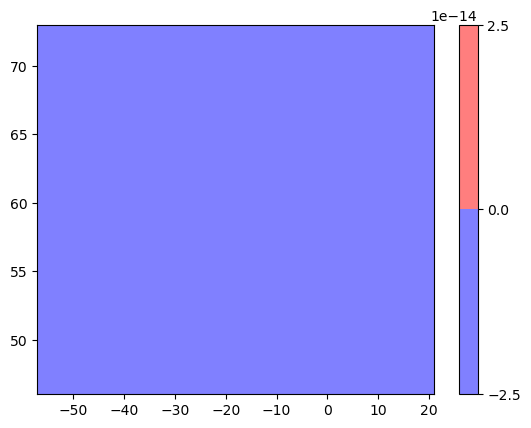

In [161]:
plt.contourf(lon, lat, y_pred.reshape(401, 401).T, cmap = 'bwr')
plt.colorbar()